<a href="https://colab.research.google.com/github/Kostia9/Data-Analysis-2025/blob/main/Lab2/Lab2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [37]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, average_precision_score, ConfusionMatrixDisplay
from sklearn.cluster import KMeans
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.svm import SVC

In [2]:
# @title kaggle
!pip install -q kaggle

from google.colab import files
files.upload()  # Виберіть kaggle.json

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d blastchar/telco-customer-churn
!unzip telco-customer-churn.zip

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/blastchar/telco-customer-churn
License(s): copyright-authors
  0% 0.00/172k [00:00<?, ?B/s]
100% 172k/172k [00:00<00:00, 405MB/s]
Archive:  telco-customer-churn.zip
  inflating: WA_Fn-UseC_-Telco-Customer-Churn.csv  


In [3]:
df = pd.read_csv("/content/WA_Fn-UseC_-Telco-Customer-Churn.csv")
print(df.shape)
df.head()

(7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


# 1. Зниження розмірності і візуалізація даних

In [4]:
df = df.drop('customerID', axis=1)
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df = df.dropna()
X = df.drop('Churn', axis=1)
y = df["Churn"].map({"No":0, "Yes":1}).astype(int)

# train/test split (stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


cols = X_train.columns.tolist()
num_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']
cat_cols = [c for c in X.columns if c not in num_cols]

# 3.1 Числові
num_scaler  = StandardScaler()

Xtr_num     = num_scaler.fit_transform(X_train[num_cols])

Xte_num     = num_scaler.transform(X_test[num_cols])

# 3.2 Категоріальні
ohe = OneHotEncoder(handle_unknown="ignore", drop="if_binary")

Xtr_cat     = ohe.fit_transform(X_train[cat_cols]).toarray()

Xte_cat     = ohe.transform(X_test[cat_cols]).toarray()

Xtr = np.hstack([Xtr_num, Xtr_cat])
Xte = np.hstack([Xte_num, Xte_cat])

print("X_train:", Xtr.shape, "X_test:", Xte.shape)
print("y_train:", y_train.shape, "y_test:", y_test.shape)

feat_names = np.array(num_cols + list(ohe.get_feature_names_out(cat_cols)))

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

X_train: (5625, 40) X_test: (1407, 40)
y_train: (5625,) y_test: (1407,)


In [5]:
pca = PCA(n_components=0.95)
Xtr_pca = pca.fit_transform(Xtr)
Xte_pca = pca.transform(Xte)

Xtr_pca.shape

(5625, 18)

In [6]:
model = SVC(C=0.1, gamma='auto', probability=True, random_state=1337)

In [7]:
%%timeit
model.fit(Xtr_pca, y_train)

5.49 s ± 531 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [8]:
%%timeit
model.fit(Xtr, y_train)

8.05 s ± 627 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [14]:
# Оцінка класифікатора з pca

model_pca = SVC(C=0.1, gamma='auto', probability=True, random_state=1337)
model_pca.fit(Xtr_pca, y_train)

y_pred_pca = model_pca.predict(Xte_pca)
y_pred_proba_pca = model_pca.predict_proba(Xte_pca)[:, 1]

accuracy_pca = accuracy_score(y_test, y_pred_pca)
precision_pca = precision_score(y_test, y_pred_pca)
recall_pca = recall_score(y_test, y_pred_pca)
f1_pca = f1_score(y_test, y_pred_pca)
roc_auc_pca = roc_auc_score(y_test, y_pred_proba_pca)
average_precision_pca = average_precision_score(y_test, y_pred_proba_pca)

In [16]:
# Навчання класифікатора без pca

model_original = SVC(C=0.1, gamma='auto', probability=True, random_state=1337)
model_original.fit(Xtr, y_train)

y_pred_original = model_original.predict(Xte)
y_pred_proba_original = model_original.predict_proba(Xte)[:, 1]

accuracy_original = accuracy_score(y_test, y_pred_original)
precision_original = precision_score(y_test, y_pred_original)
recall_original = recall_score(y_test, y_pred_original)
f1_original = f1_score(y_test, y_pred_original)
roc_auc_original = roc_auc_score(y_test, y_pred_proba_original)
average_precision_original = average_precision_score(y_test, y_pred_proba_original)

## Порівняння

In [17]:
print("Comparison of Classifier Performance (Original vs. PCA-reduced Data):")
print("-" * 60)
print(f"{'Metric':<15} | {'Original Data':<15} | {'PCA-reduced Data':<15}")
print("-" * 60)
print(f"{'Accuracy':<15} | {accuracy_original:<15.4f} | {accuracy_pca:<15.4f}")
print(f"{'Precision':<15} | {precision_original:<15.4f} | {precision_pca:<15.4f}")
print(f"{'Recall':<15} | {recall_original:<15.4f} | {recall_pca:<15.4f}")
print(f"{'F1-score':<15} | {f1_original:<15.4f} | {f1_pca:<15.4f}")
print(f"{'ROC-AUC':<15} | {roc_auc_original:<15.4f} | {roc_auc_pca:<15.4f}")
print(f"{'AP':<15} | {average_precision_original:<15.4f} | {average_precision_pca:<15.4f}")

print("-" * 60)

Comparison of Classifier Performance (Original vs. PCA-reduced Data):
------------------------------------------------------------
Metric          | Original Data   | PCA-reduced Data
------------------------------------------------------------
Accuracy        | 0.7903          | 0.7875         
Precision       | 0.6406          | 0.6415         
Recall          | 0.4813          | 0.4545         
F1-score        | 0.5496          | 0.5321         
ROC-AUC         | 0.8245          | 0.8089         
AP              | 0.6180          | 0.6093         
------------------------------------------------------------


## Застосування t-sne



In [18]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
Xtr_tsne = tsne.fit_transform(Xtr)

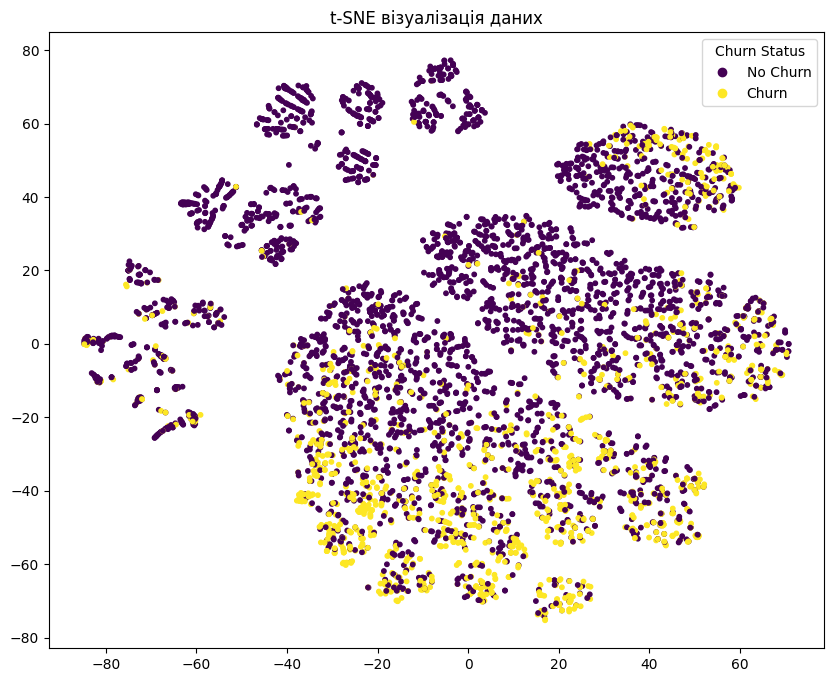

In [19]:
plt.figure(figsize=(10, 8))
scatter = plt.scatter(Xtr_tsne[:, 0], Xtr_tsne[:, 1], c=y_train, cmap='viridis', s=10)
plt.title('t-SNE візуалізація даних')
legend_labels = {0: 'No Churn', 1: 'Churn'}
plt.legend(handles=scatter.legend_elements()[0], labels=[legend_labels[0], legend_labels[1]], title="Churn Status")
plt.show()

# 2. Кластерний аналіз

Implement k-means clustering for image quantization with 64, 32, 16, and 8 color levels on a chosen image, then visualize and compare the resulting images.

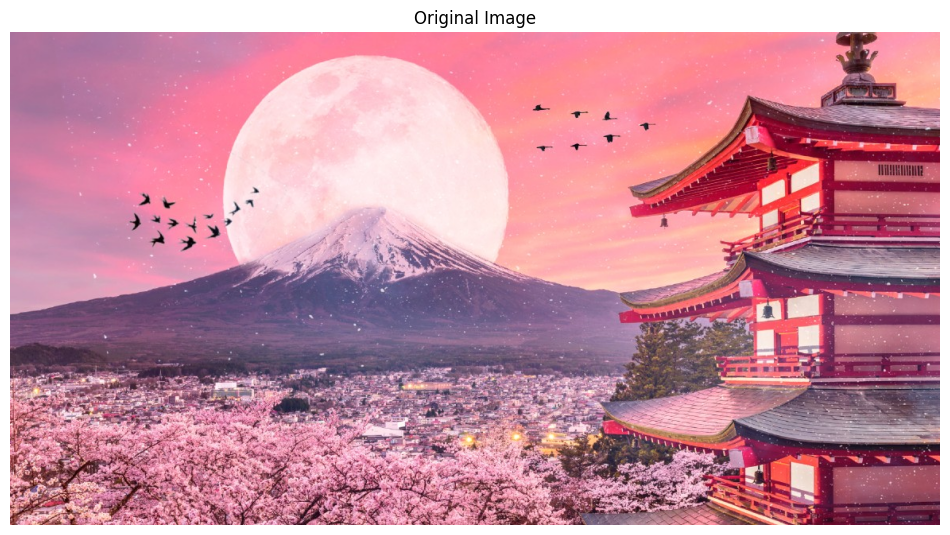

In [22]:
img = mpimg.imread('/content/image.jpg')
plt.figure(figsize=(12,8))
plt.imshow(img)
plt.title("Original Image")
plt.axis('off')
plt.show()

## Застосування k-means



In [23]:
reconstructed_images = {}
n_clusters_list = [64, 32, 16, 8]

img_reshaped = np.reshape(img, (-1, 3)) # (height*width, 3)
original_shape = img.shape

for n_clusters in n_clusters_list:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init='auto')
    kmeans.fit(img_reshaped)

    # Reconstruct the image
    labels = kmeans.labels_
    quantized_pixels = kmeans.cluster_centers_[labels]
    reconstructed_image = quantized_pixels.reshape(original_shape)
    reconstructed_images[n_clusters] = reconstructed_image

## Візуалізація та порівняння


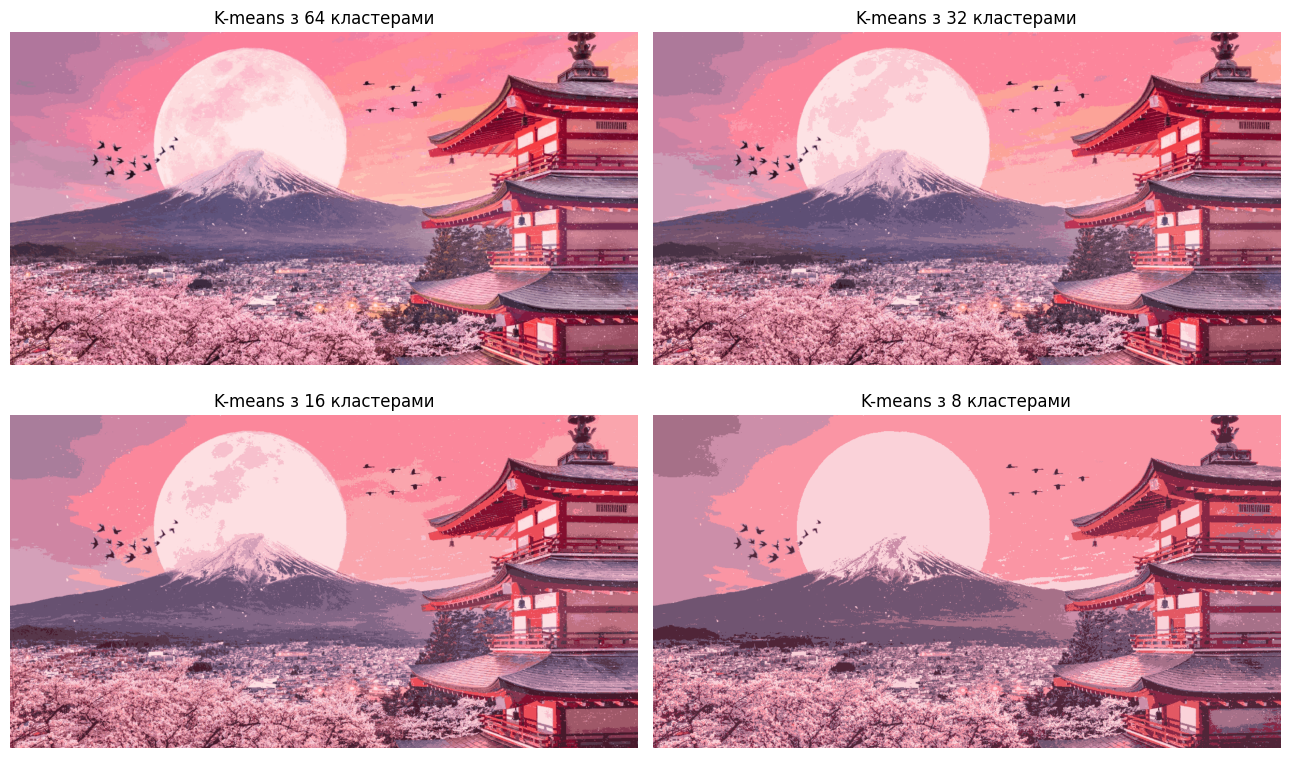

In [24]:
fig, axes = plt.subplots(2, 2, figsize=(13, 8))
axes = axes.ravel()

for i, (n_clusters, reconstructed_image) in enumerate(reconstructed_images.items()):
    ax = axes[i]
    ax.imshow(reconstructed_image.astype(np.uint8))
    ax.set_title(f'K-means з {n_clusters} кластерами')
    ax.axis('off')

plt.tight_layout()
plt.show()

# 3. Обробка та класифікація текстових даних

In [25]:
# @title kaggle
!pip install -q kaggle

from google.colab import files
files.upload()  # Виберіть kaggle.json

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d bittlingmayer/amazonreviews
!unzip amazonreviews.zip

Saving kaggle.json to kaggle (1).json
Dataset URL: https://www.kaggle.com/datasets/bittlingmayer/amazonreviews
License(s): unknown
 98% 484M/493M [00:07<00:00, 59.0MB/s]
100% 493M/493M [00:08<00:00, 64.1MB/s]
Archive:  amazonreviews.zip
  inflating: test.ft.txt.bz2         
  inflating: train.ft.txt.bz2        


In [26]:
import bz2
import pandas as pd
import re

def extractData(filename, n_samples=None):
    data = []
    with bz2.open(filename, 'rt', encoding='utf-8') as f:
        for i, line in enumerate(f):
            if n_samples is not None and i >= n_samples:
                break
            parts = line.strip().split(' ', 1)
            if len(parts) == 2:
                label, text = parts
                data.append((label, text))
    df = pd.DataFrame(data, columns=['label', 'text'])
    df['label'] = df['label'].str.extract(r'(\d+)').astype(int)
    return df

train = extractData('train.ft.txt.bz2', n_samples=200_000)
test = extractData('test.ft.txt.bz2')

train.head()

,label,text
0,2,Stuning even for the non-gamer: This sound tra...
1,2,The best soundtrack ever to anything.: I'm rea...
2,2,Amazing!: This soundtrack is my favorite music...
3,2,Excellent Soundtrack: I truly like this soundt...
4,2,"Remember, Pull Your Jaw Off The Floor After He..."


__label__1 corresponds to 1- and 2-star reviews, and __label__2 corresponds to 4- and 5-star reviews.

In [32]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text) # Remove non-word characters and whitespace
    text = re.sub(r'\d+', '', text) # Remove digits
    return text.strip()

train['clean_text'] = train['text'].apply(clean_text)
test['clean_text']  = test['text'].apply(clean_text)
train = train[train['label'].isin([1,2])].reset_index(drop=True)
test  = test[test['label'].isin([1,2])].reset_index(drop=True)
train['label'] -= 1
test['label']  -= 1

train.head()

,label,text,clean_text
0,0,Stuning even for the non-gamer: This sound tra...,stuning even for the nongamer this sound track...
1,0,The best soundtrack ever to anything.: I'm rea...,the best soundtrack ever to anything im readin...
2,0,Amazing!: This soundtrack is my favorite music...,amazing this soundtrack is my favorite music o...
3,0,Excellent Soundtrack: I truly like this soundt...,excellent soundtrack i truly like this soundtr...
4,0,"Remember, Pull Your Jaw Off The Floor After He...",remember pull your jaw off the floor after hea...


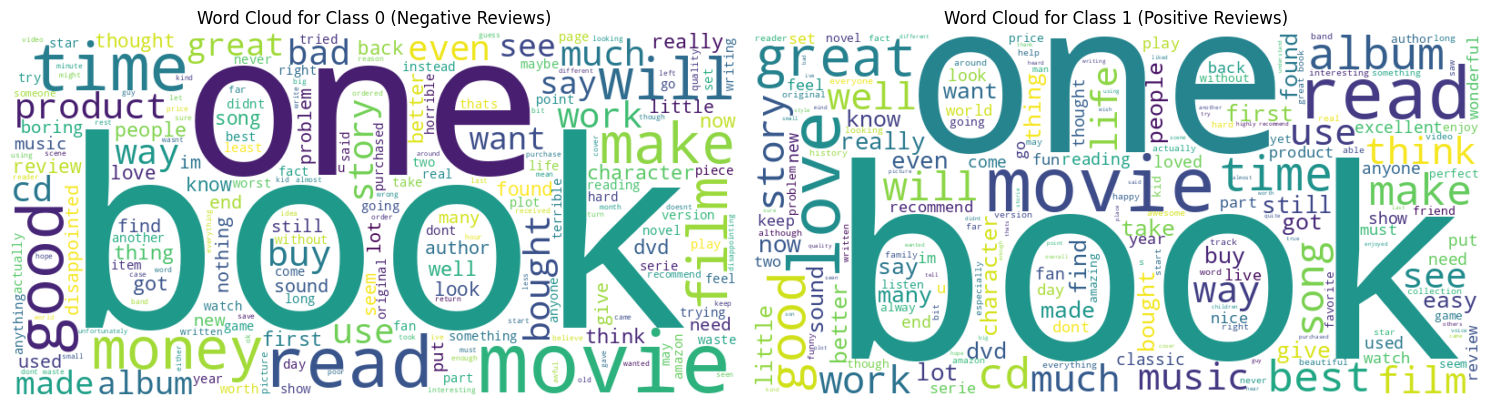

In [28]:
from wordcloud import WordCloud

# Combine text for each class
text_class_0 = " ".join(train[train['label'] == 0]['clean_text'].tolist())
text_class_1 = " ".join(train[train['label'] == 1]['clean_text'].tolist())

# Generate WordCloud for class 0
wordcloud_0 = WordCloud(width=800, height=400, background_color='white').generate(text_class_0)

# Generate WordCloud for class 1
wordcloud_1 = WordCloud(width=800, height=400, background_color='white').generate(text_class_1)

# Plot the WordClouds
plt.figure(figsize=(15, 10))

plt.subplot(1, 2, 1)
plt.imshow(wordcloud_0, interpolation='bilinear')
plt.title('Word Cloud for Class 0 (Negative Reviews)')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_1, interpolation='bilinear')
plt.title('Word Cloud for Class 1 (Positive Reviews)')
plt.axis('off')

plt.tight_layout()
plt.show()

In [29]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

X_train, y_train = train['clean_text'], train['label']
X_test, y_test = test['clean_text'], test['label']

print("Class distribution in training data:")
print(y_train.value_counts())
print("\nClass distribution in testing data:")
print(y_test.value_counts())

Class distribution in training data:
label
1    101166
0     98834
Name: count, dtype: int64

Class distribution in testing data:
label
1    200000
0    200000
Name: count, dtype: int64


In [30]:
vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1,2))
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

              precision    recall  f1-score   support

           0      0.913     0.913     0.913    200000
           1      0.913     0.913     0.913    200000

    accuracy                          0.913    400000
   macro avg      0.913     0.913     0.913    400000
weighted avg      0.913     0.913     0.913    400000



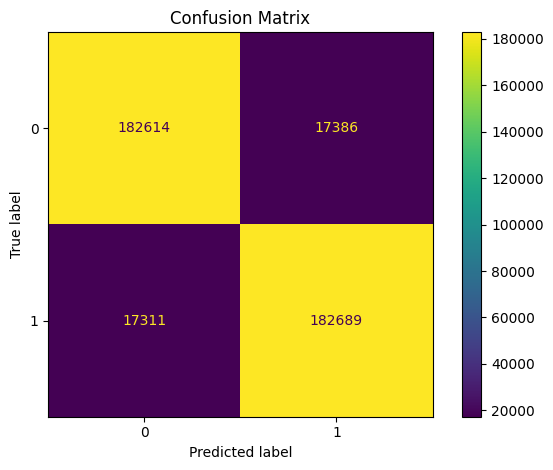

In [38]:
clf = LogisticRegression(random_state=42)
clf.fit(X_train_vec, y_train)

y_pred = clf.predict(X_test_vec)
print(classification_report(y_test, y_pred, digits=3))

cm  = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm, display_labels=['0','1']).plot()
plt.title(f"Confusion Matrix")
plt.tight_layout(); plt.show()

In [39]:
# Додамо приклади передбачень у вигляді таблиці
print("\nExamples of predictions with probabilities:")

# Get predicted probabilities for the positive class (label 1)
y_pred_proba = clf.predict_proba(X_test_vec)[:, 1]

# Create a DataFrame to display the comparison
predictions_df = pd.DataFrame({
    'Sentence': X_test.iloc[:5],
    'Actual Label': y_test.iloc[:5],
    'Predicted Probability (Class 1)': y_pred_proba[:5],
    'Predicted Label': y_pred[:5]
})

pd.set_option('display.max_colwidth', None)
display(predictions_df)
pd.reset_option('display.max_colwidth')


Examples of predictions with probabilities:


,Sentence,Actual Label,Predicted Probability (Class 1),Predicted Label
0,great cd my lovely pat has one of the great voices of her generation i have listened to this cd for years and i still love it when im in a good mood it makes me feel better a bad mood just evaporates like sugar in the rain this cd just oozes life vocals are jusat stuunning and lyrics just kill one of lifes hidden gems this is a desert isle cd in my book why she never made it big is just beyond me everytime i play this no matter black white young old male female everybody says one thing who was that singing,1,0.933815,1
1,one of the best game music soundtracks for a game i didnt really play despite the fact that i have only played a small portion of the game the music i heard plus the connection to chrono trigger which was great as well led me to purchase the soundtrack and it remains one of my favorite albums there is an incredible mix of fun epic and emotional songs those sad and beautiful tracks i especially like as theres not too many of those kinds of songs in my other video game soundtracks i must admit that one of the songs lifea distant promise has brought tears to my eyes on many occasionsmy one complaint about this soundtrack is that they use guitar fretting effects in many of the songs which i find distracting but even if those werent included i would still consider the collection worth it,1,0.994431,1
2,batteries died within a year i bought this charger in jul and it worked ok for a while the design is nice and convenient however after about a year the batteries would not hold a charge might as well just get alkaline disposables or look elsewhere for a charger that comes with batteries that have better staying power,0,0.036678,0
3,works fine but maha energy is better check out maha energys website their powerex mhcf charger works in minutes for rapid charge with option for slower charge better for batteries and they have mah batteries,1,0.319881,0
4,great for the nonaudiophile reviewed quite a bit of the combo players and was hesitant due to unfavorable reviews and size of machines i am weaning off my vhs collection but dont want to replace them with dvds this unit is well built easy to setup and resolution and special effects no progressive scan for hdtv owners suitable for many people looking for a versatile productcons no universal remote,1,0.769462,1
